<div style="display: flex;">
    <a href="https://t.me/nsbarsukov" style="margin-right:20px;">
        <img src="https://img.shields.io/badge/Telegram-2CA5E0?style=for-the-badge&logo=telegram&logoColor=white" alt="write-me-telegram"/>
    </a>
    <a href="https://github.com/nsbarsukov/toxic-comments-detector" style="margin-right:20px;">
        <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="Open Github"/>
    </a>
</div>
<div style="display: flex; margin-top: 20px;">
    <a href="https://colab.research.google.com/github/nsbarsukov/toxic-comments-detector/blob/master/models/09weightedCNN%2BUSE%2BaugmentedData.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
</div>

In [1]:
MODEL_NAME = 'weightedCNN_USE_augmentedData'

In [2]:
import os

def check_is_google_colab():
    return 'google.colab' in str(get_ipython())


def prepare_environment():
    if check_is_google_colab():
        from google.colab import drive
        import shutil
        
        drive.mount('/content/gdrive/')

        PATH_TO_TEMP_REPO = '/content/gdrive/My Drive/toxic-comments-repo-temp'

        try:
            shutil.rmtree(PATH_TO_TEMP_REPO)
        except:
            pass

        os.mkdir(PATH_TO_TEMP_REPO)
        
        %cd ./gdrive/My Drive/toxic-comments-repo-temp
        ! git clone https://github.com/nsbarsukov/toxic-comments-detector.git .
        ! pip3 install -q tensorflow_text
    else:
        %cd ..

prepare_environment()

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [3]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    load_translated_from_english_cleaned_russian_text_data,
    get_class_weights,
    get_initial_output_bias,
    evaluate_model,
    show_tf_model_summary,
    early_stopping_cb,
    save_tf_model,
    SEED,
    VALIDATION_SPLIT_PARTITION,
    DEFAULT_BATCH_SIZE,
    DEFAULT_EPOCHS
)
from wordEmbeddingsLayers import create_universal_sentence_encoder_layer, USE_SENTENCE_EMBEDDING_DIMENSION

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Build CNN model

In [4]:
X_translated_pretrain, y_translated_pretrain = load_translated_from_english_cleaned_russian_text_data()
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [5]:
from tensorflow.keras import layers, losses

model = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string, name='Raw_text'),
    create_universal_sentence_encoder_layer(),
    
    layers.Reshape((USE_SENTENCE_EMBEDDING_DIMENSION, 1)),
    layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
    layers.GlobalMaxPool1D(),
    
    layers.Dense(units=128, activation='relu', name='FC_Layer_Relu'),
    layers.Dropout(rate=0.5, seed=SEED, name='Regularization'),
    layers.Dense(
        units=1,
        name='FC_Layer_sigmoid',
        activation='sigmoid'
    ),
], name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [6]:
pretrain_history = model.fit(
    x=X_translated_pretrain,
    y=y_translated_pretrain,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH_SIZE,
    validation_split=VALIDATION_SPLIT_PARTITION,
    callbacks=[early_stopping_cb],
)

Epoch 1/10
16/16 [==============================] - 83s 5s/step - loss: 0.6918 - binary_accuracy: 0.5302 - recall: 0.1536 - precision: 0.5811 - val_loss: 0.6671 - val_binary_accuracy: 0.7850 - val_recall: 0.6504 - val_precision: 0.8800
Epoch 2/10
16/16 [==============================] - 72s 4s/step - loss: 0.6353 - binary_accuracy: 0.7709 - recall: 0.6405 - precision: 0.8666 - val_loss: 0.5236 - val_binary_accuracy: 0.8365 - val_recall: 0.8889 - val_precision: 0.8000
Epoch 3/10
16/16 [==============================] - 72s 5s/step - loss: 0.4630 - binary_accuracy: 0.8816 - recall: 0.8998 - precision: 0.8685 - val_loss: 0.4262 - val_binary_accuracy: 0.8405 - val_recall: 0.9103 - val_precision: 0.7945
Epoch 4/10
16/16 [==============================] - 74s 5s/step - loss: 0.2986 - binary_accuracy: 0.9229 - recall: 0.9481 - precision: 0.9039 - val_loss: 0.4020 - val_binary_accuracy: 0.8450 - val_recall: 0.8970 - val_precision: 0.8081
Epoch 5/10
16/16 [==============================] - 81s 

In [7]:
negative_class_amount, pos_class_amount = np.bincount(y_train)

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH_SIZE,
    validation_split=VALIDATION_SPLIT_PARTITION,
    callbacks=[early_stopping_cb],
    class_weight=get_class_weights(pos_class_amount, negative_class_amount),
)

Epoch 1/10
19/19 [==============================] - 61s 3s/step - loss: 0.3731 - binary_accuracy: 0.8419 - recall: 0.8808 - precision: 0.7153 - val_loss: 0.2895 - val_binary_accuracy: 0.8886 - val_recall: 0.8581 - val_precision: 0.8166
Epoch 2/10
19/19 [==============================] - 54s 3s/step - loss: 0.2068 - binary_accuracy: 0.9295 - recall: 0.9584 - precision: 0.8510 - val_loss: 0.2845 - val_binary_accuracy: 0.8981 - val_recall: 0.8867 - val_precision: 0.8215
Epoch 3/10
19/19 [==============================] - 55s 3s/step - loss: 0.1363 - binary_accuracy: 0.9579 - recall: 0.9839 - precision: 0.9004 - val_loss: 0.4346 - val_binary_accuracy: 0.8491 - val_recall: 0.9453 - val_precision: 0.7035
Epoch 4/10
19/19 [==============================] - 55s 3s/step - loss: 0.1734 - binary_accuracy: 0.9342 - recall: 0.9894 - precision: 0.8425 - val_loss: 0.3693 - val_binary_accuracy: 0.8608 - val_recall: 0.9440 - val_precision: 0.7228
Epoch 5/10
19/19 [==============================] - 55s 

# Model evaluation

Accuracy: 91.43%
Recall: 88.26%
Precision: 86.18%
F1-score: 87.21% 



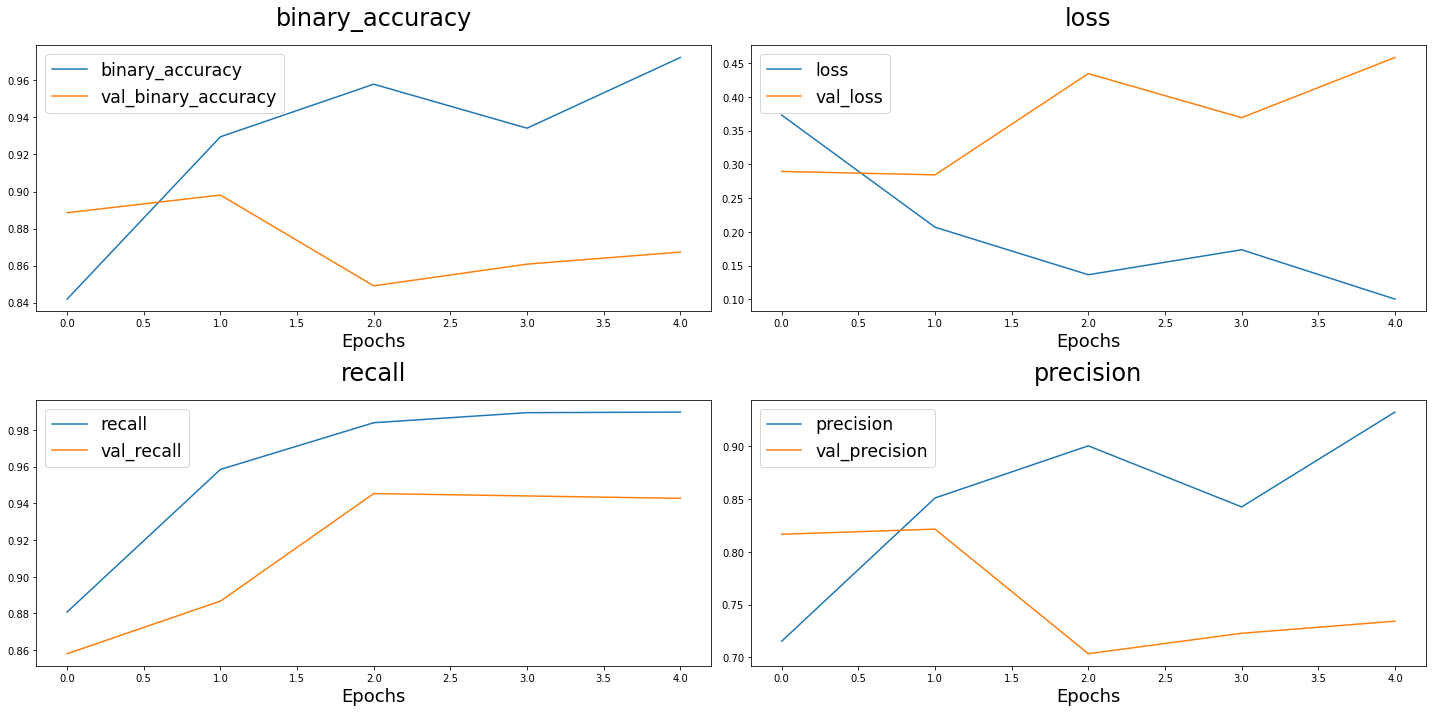

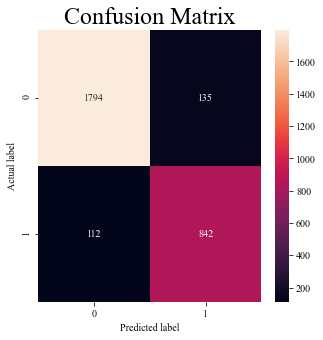

In [8]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, tf_history_learning=history, model_name=MODEL_NAME)

Model: "weightedCNN_USE_augmentedData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               68927232  
_________________________________________________________________
reshape (Reshape)            (None, 512, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 256)          1536      
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
FC_Layer_Relu (Dense)        (None, 128)               32896     
_________________________________________________________________
Regularization (Dropout)     (None, 128)               0         
_________________________________________________________________
FC_Layer_sigmoid (Dense)     (None, 1

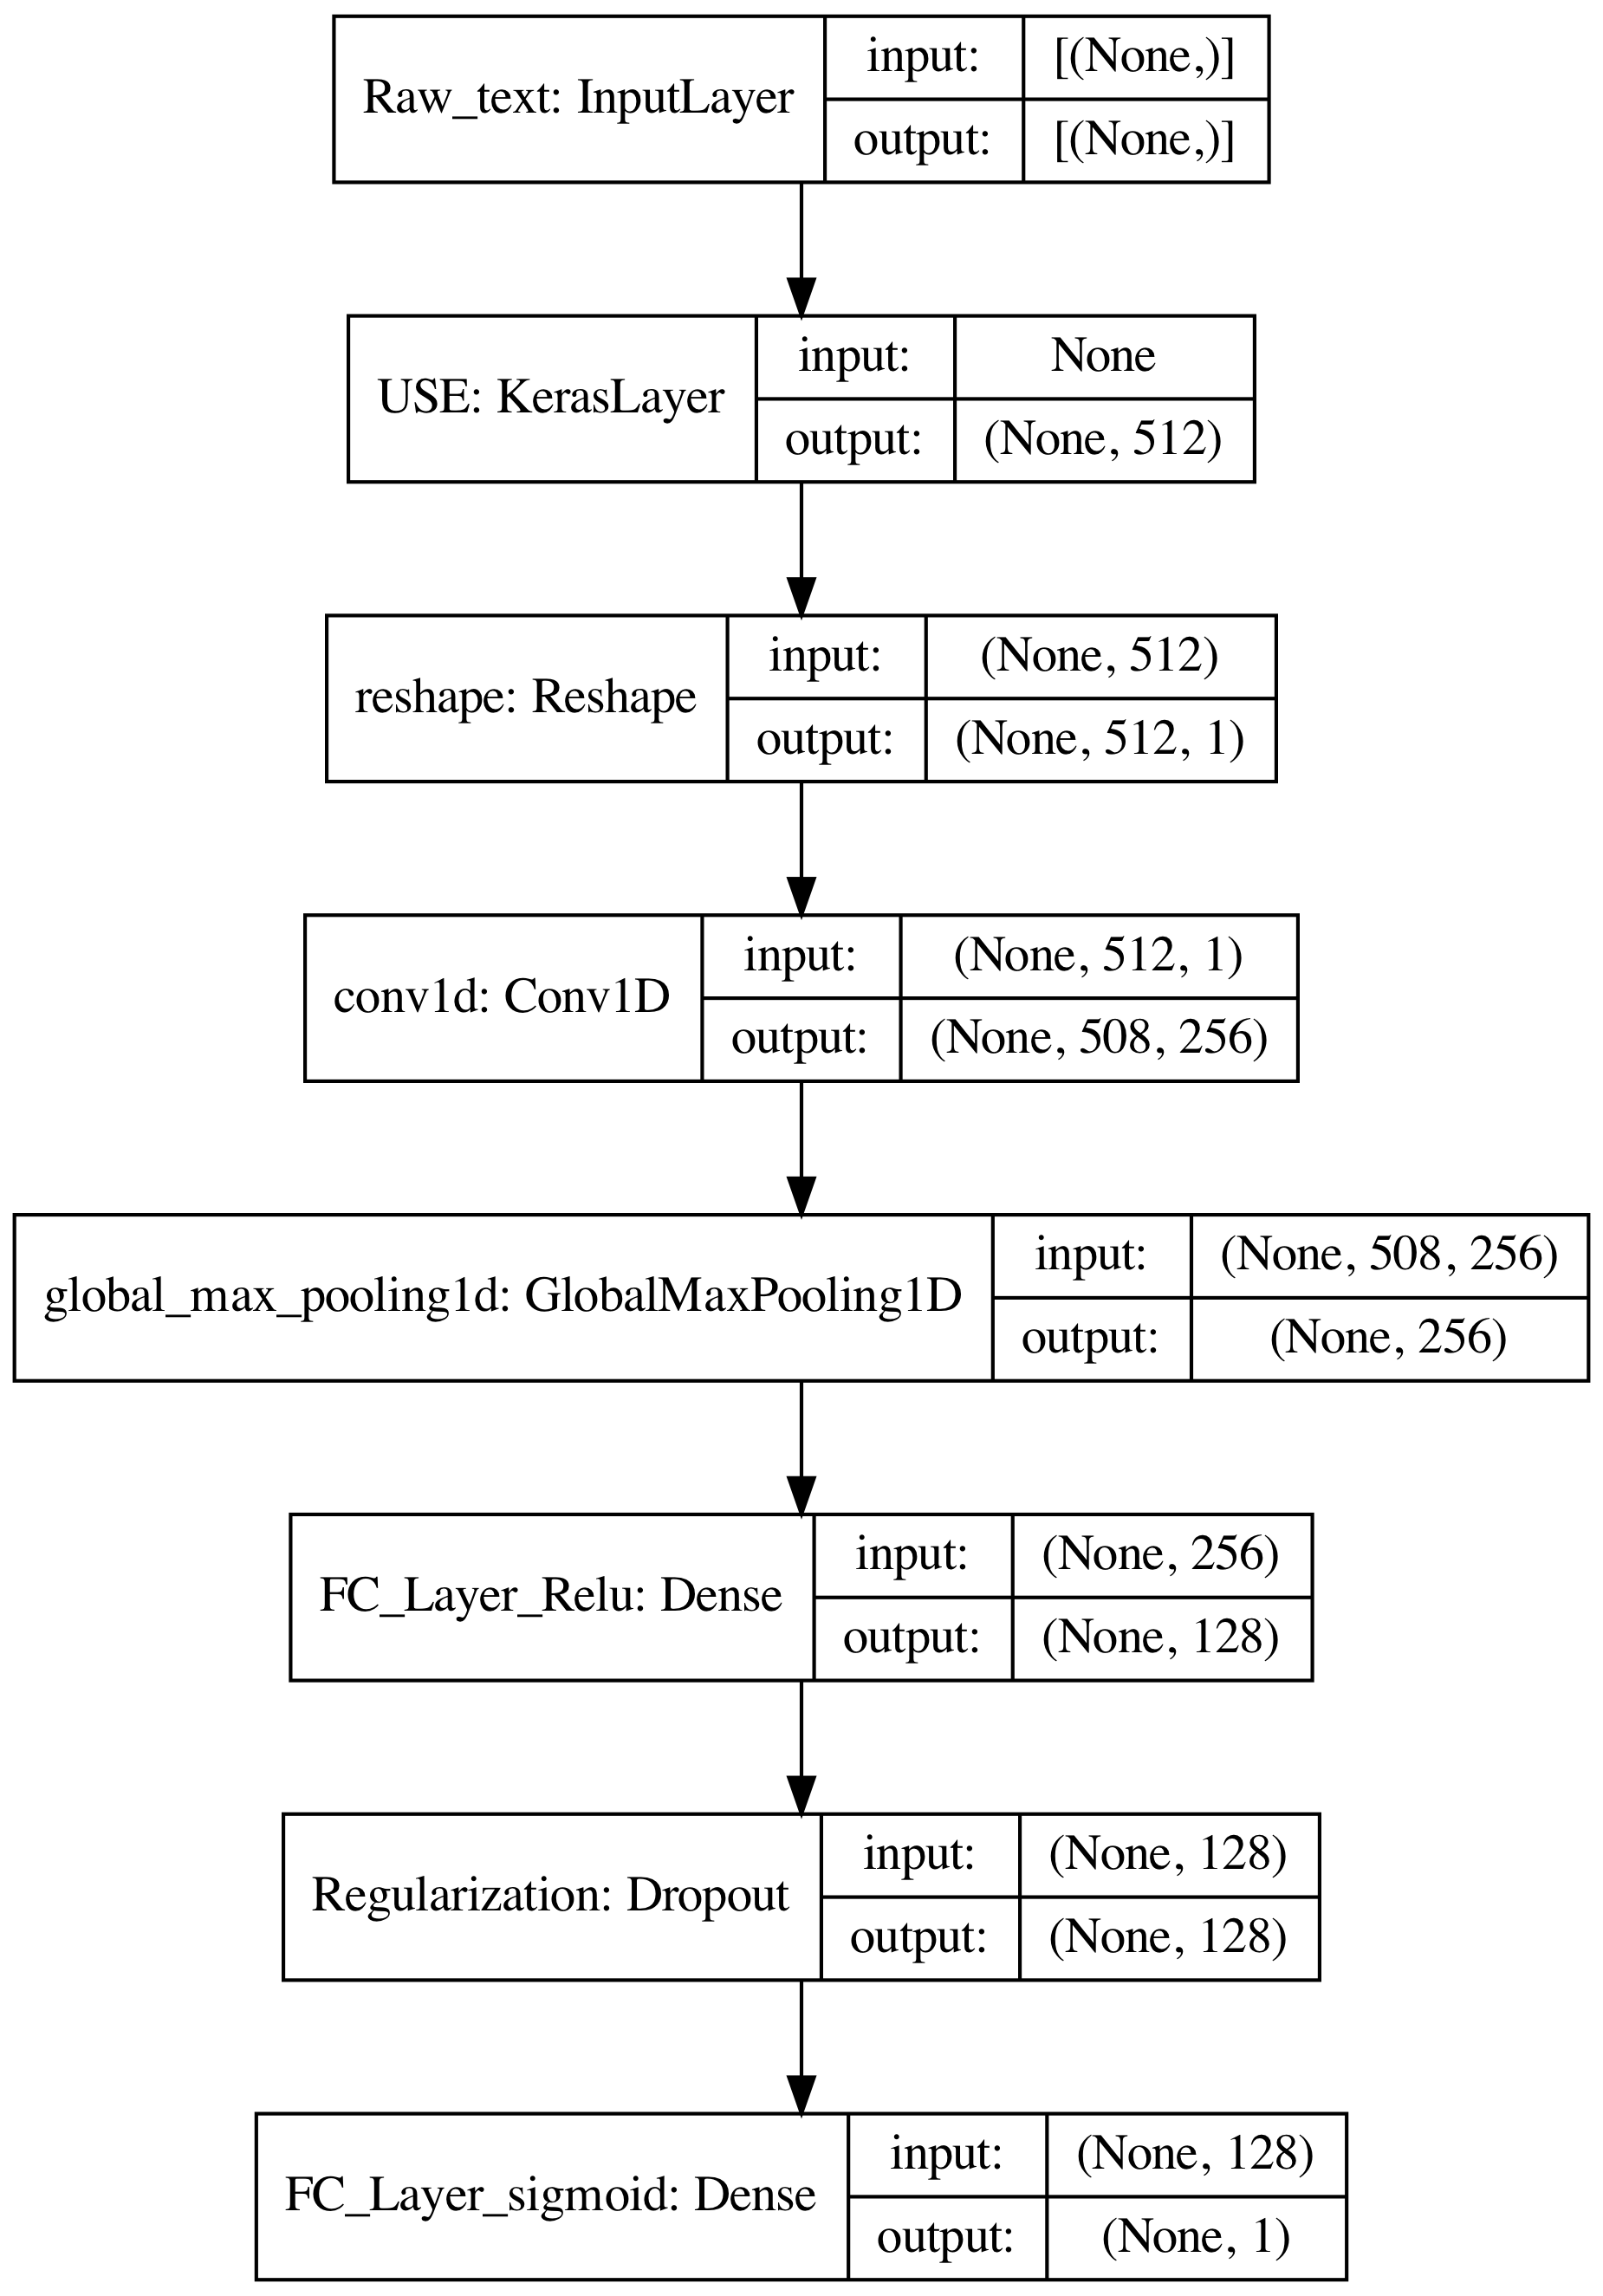

In [9]:
show_tf_model_summary(model)

In [10]:
save_tf_model(model)

INFO:tensorflow:Assets written to: .savedModels/weightedCNN_USE_augmentedData/assets


INFO:tensorflow:Assets written to: .savedModels/weightedCNN_USE_augmentedData/assets


In [11]:
from dev import DIRECTORY_WITH_SAVED_MODELS
from textPreprocessing import preprocess_text

loaded_model = tf.keras.models.load_model(f'{DIRECTORY_WITH_SAVED_MODELS}/{model.name}')

raw_texts = ['ты чего берега попутал?', 'это правый берег реки, не путай с левым']
preprocessed_texts = list(map(preprocess_text, raw_texts))

loaded_model.predict(preprocessed_texts)

array([[0.9229312],
       [0.0186432]], dtype=float32)

In [13]:
# TODO
# https://www.tensorflow.org/lite/performance/post_training_quantization
# https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python

# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir = f'{DIRECTORY_WITH_SAVED_MODELS}/{MODEL_NAME}')
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# tflite_quant_model = converter.convert()
# open("converted_model.tflite", "wb").write(tflite_model)


# interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
# interpreter.allocate_tensors()

# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# input_shape = input_details[0]['shape']
# input_data = np.array([ preprocessed_texts[0] ])
# interpreter.set_tensor(input_details[0]['index'], input_data)

# interpreter.invoke()

# output_data = interpreter.get_tensor(output_details[0]['index'])
# print(output_data)